In [45]:
import os
import sys
import math
import pickle
import random
import librosa
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf
import tensorflow as tf
import vggish.vggish as vggish
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline
tf.get_logger().setLevel('INFO')
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# OPENMIC

In [3]:
df_openmic = pd.read_csv('openmic/openmic-2018-aggregated-labels.csv')
df_openmic.head()

,sample_key,instrument,relevance,num_responses
0,000046_3840,clarinet,0.17105,3
1,000046_3840,flute,0.00000,3
2,000046_3840,trumpet,0.00000,3
3,000135_483840,saxophone,0.14705,3
4,000135_483840,voice,1.00000,3


In [4]:
df_openmic.shape

(41534, 4)

In [5]:
df_openmic['instrument'].value_counts()

instrument
trumpet              2928
trombone             2783
mandolin             2477
ukulele              2437
clarinet             2398
saxophone            2377
banjo                2229
flute                2095
accordion            2093
violin               2047
cello                1960
organ                1901
bass                 1900
mallet_percussion    1814
drums                1759
cymbals              1749
piano                1733
guitar               1664
synthesizer          1614
voice                1576
Name: count, dtype: int64

In [6]:
split_train = pd.read_csv('openmic/partitions/split01_train.csv', header=None).squeeze()
split_test = pd.read_csv('openmic/partitions/split01_test.csv', header=None).squeeze()

print(f'Train: {len(split_train)}\nTest: {len(split_test)}')

Train: 14915
Test: 5085


In [7]:
inst_openmic = ['bass', 'drums', 'guitar', 'piano', 'voice']

In [8]:
inst_openmic_nsynth = ['bass', 'guitar', 'synthesizer', 'voice']

# Demucs

In [9]:
df_demucs = pd.read_csv('separated/demucs-instruments.csv')
df_demucs.head()

,track_id,instrument,track
0,track_0_0,bass,the-less-i-know-the-better
1,track_0_1,bass,the-less-i-know-the-better
2,track_0_2,bass,the-less-i-know-the-better
3,track_0_3,bass,the-less-i-know-the-better
4,track_0_4,bass,the-less-i-know-the-better


In [10]:
df_demucs.shape

(949, 3)

In [11]:
df_demucs['instrument'].value_counts()

instrument
guitar    232
vocals    215
bass      201
drums     193
piano     108
Name: count, dtype: int64

In [12]:
DEMUCS = np.load('separated/demucs_features.npz', allow_pickle=True)

In [13]:
X_d, Y_true_d, track_id_d = DEMUCS['X'], DEMUCS['Y_mask'], DEMUCS['track_id']

# NSynth

In [14]:
df_nsynth = pd.read_csv('nsynth/nsynth_instruments.csv')
df_nsynth.head()

,track_id,instrument,predicted
0,keyboard_electronic_008-067-075,synthesizer,synthesizer
1,keyboard_acoustic_009-073-127,synthesizer,guitar
2,keyboard_electronic_109-056-100,synthesizer,synthesizer
3,keyboard_electronic_059-094-025,synthesizer,synthesizer
4,keyboard_electronic_005-069-025,synthesizer,synthesizer


In [15]:
df_nsynth.shape

(4000, 3)

In [16]:
df_nsynth['instrument'].value_counts()

instrument
synthesizer    1000
guitar         1000
bass           1000
voice          1000
Name: count, dtype: int64

In [17]:
NSYNTH = np.load('nsynth/features.npz', allow_pickle=True)

In [18]:
X_ns, Y_true_ns, track_id_ns = NSYNTH['X'], NSYNTH['Y_mask'], NSYNTH['track_id']

## Treinamento Nsynth

In [7]:
instruments = np.unique(df_nsynth['instrument'])
instruments

array(['bass', 'guitar', 'keyboard', 'vocal'], dtype=object)

In [8]:
class_map = {inst: i for i, inst in enumerate(instruments)}
class_map

{'bass': 0, 'guitar': 1, 'keyboard': 2, 'vocal': 3}

In [9]:
x_split = df_nsynth['track_id']
y_split = df_nsynth['instrument']
x_train, x_test, y_train, y_test = train_test_split(x_split, y_split, test_size=0.2, random_state=42)

In [10]:
print(f'Train: {len(x_train)}\nTest: {len(x_test)}')

Train: 3200
Test: 800


In [11]:
train_set = set(x_train)
test_set = set(x_test)

In [12]:
idx_train, idx_test = [], []

for idx, n in enumerate(track_id):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [13]:
X_train = X[idx_train]
X_test = X[idx_test]

Y_train = Y_true[idx_train]
Y_test = Y_true[idx_test]

In [14]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_test shape: {Y_test.shape}')

X_train shape: (3200, 4, 128)
X_test shape: (800, 4, 128)
Y_train shape: (3200, 4)
Y_test shape: (800, 4)


In [17]:
models = dict()

for idx, instrument in enumerate(class_map):
    train_inst = Y_train[:, idx]
    test_inst = Y_test[:, idx]
    
    X_train_inst = X_train[train_inst == 1]  
    X_train_other = X_train[train_inst != 1] 
    X_train_inst_sklearn = np.mean(X_train_inst, axis=1)
    X_train_other_sklearn = np.mean(X_train_other, axis=1)
    
    Y_true_train_inst = np.ones(len(X_train_inst), dtype=bool)  
    Y_true_train_other = np.zeros(len(X_train_other), dtype=bool)  
    Y_true_train = np.concatenate((Y_true_train_inst, Y_true_train_other))
    
    X_test_inst = X_test[test_inst == 1]  
    X_test_other = X_test[test_inst != 1]  
    X_test_inst_sklearn = np.mean(X_test_inst, axis=1)
    X_test_other_sklearn = np.mean(X_test_other, axis=1)
    
    Y_true_test_inst = np.ones(len(X_test_inst), dtype=bool)  
    Y_true_test_other = np.zeros(len(X_test_other), dtype=bool)  
    Y_true_test = np.concatenate((Y_true_test_inst, Y_true_test_other))

    clf = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=0)
    
    X_train_combined = np.concatenate((X_train_inst_sklearn, X_train_other_sklearn))
    clf.fit(X_train_combined, Y_true_train)

    Y_pred_train = clf.predict(X_train_combined)
    Y_pred_test = clf.predict(np.concatenate((X_test_inst_sklearn, X_test_other_sklearn)))
    
    print('-' * 52)
    print(instrument)
    print('\tTRAIN')
    print(classification_report(Y_true_train, Y_pred_train))
    print('\tTEST')
    print(classification_report(Y_true_test, Y_pred_test))
    
    models[instrument] = clf

----------------------------------------------------
bass
	TRAIN
              precision    recall  f1-score   support

       False       0.94      0.99      0.97      2394
        True       0.98      0.82      0.89       806

    accuracy                           0.95      3200
   macro avg       0.96      0.91      0.93      3200
weighted avg       0.95      0.95      0.95      3200

	TEST
              precision    recall  f1-score   support

       False       0.86      0.95      0.90       606
        True       0.75      0.51      0.61       194

    accuracy                           0.84       800
   macro avg       0.80      0.73      0.75       800
weighted avg       0.83      0.84      0.83       800

----------------------------------------------------
guitar
	TRAIN
              precision    recall  f1-score   support

       False       0.94      0.99      0.96      2413
        True       0.96      0.80      0.87       787

    accuracy                           0.94 

# MTG-Jamendo

In [19]:
df_jamendo = pd.read_csv('mtg-jamendo/selected-instruments-splitted.csv')
df_jamendo.head()

,track_id,instrument
0,track_0151154_0,piano
1,track_0151154_1,piano
2,track_0151154_2,piano
3,track_0151154_3,piano
4,track_0151154_4,piano


In [20]:
df_jamendo.shape

(6151, 2)

In [21]:
df_jamendo['instrument'].value_counts()

instrument
acousticguitar    1521
electricguitar    1336
bass              1224
drums              780
piano              740
voice              550
Name: count, dtype: int64

In [22]:
JAMENDO = np.load('mtg-jamendo/new_features.npz', allow_pickle=True)

In [23]:
X_j, Y_true_j, track_id_j = JAMENDO['X'], JAMENDO['Y_mask'], JAMENDO['track_id']

## Training MTG-Jamendo

In [18]:
instruments = np.unique(df_jamendo['instrument'])
instruments

array(['acousticguitar', 'bass', 'drums', 'electricguitar', 'piano',
       'voice'], dtype=object)

In [19]:
class_map = {inst: i for i, inst in enumerate(instruments)}
class_map

{'acousticguitar': 0,
 'bass': 1,
 'drums': 2,
 'electricguitar': 3,
 'piano': 4,
 'voice': 5}

In [14]:
x_split = df_jamendo['track_id']
y_split = df_jamendo['instrument']
x_train, x_test, y_train, y_test = train_test_split(x_split, y_split, test_size=0.2, random_state=42)

In [15]:
print(f'Train: {len(x_train)}\nTest: {len(x_test)}')

Train: 4920
Test: 1231


In [16]:
train_set = set(x_train)
test_set = set(x_test)

In [17]:
idx_train, idx_test = [], []

for idx, n in enumerate(track_id):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [18]:
X_train = X[idx_train]
X_test = X[idx_test]

Y_train = Y_true[idx_train]
Y_test = Y_true[idx_test]

In [19]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_test shape: {Y_test.shape}')

X_train shape: (4920, 10, 128)
X_test shape: (1231, 10, 128)
Y_train shape: (4920, 6)
Y_test shape: (1231, 6)


In [20]:
models = dict()

for idx, instrument in enumerate(class_map):
    train_inst = Y_train[:, idx]
    test_inst = Y_test[:, idx]
    
    X_train_inst = X_train[train_inst == 1]  
    X_train_other = X_train[train_inst != 1] 
    X_train_inst_sklearn = np.mean(X_train_inst, axis=1)
    X_train_other_sklearn = np.mean(X_train_other, axis=1)
    
    Y_true_train_inst = np.ones(len(X_train_inst), dtype=bool)  
    Y_true_train_other = np.zeros(len(X_train_other), dtype=bool)  
    Y_true_train = np.concatenate((Y_true_train_inst, Y_true_train_other))
    
    X_test_inst = X_test[test_inst == 1]  
    X_test_other = X_test[test_inst != 1]  
    X_test_inst_sklearn = np.mean(X_test_inst, axis=1)
    X_test_other_sklearn = np.mean(X_test_other, axis=1)
    
    Y_true_test_inst = np.ones(len(X_test_inst), dtype=bool)  
    Y_true_test_other = np.zeros(len(X_test_other), dtype=bool)  
    Y_true_test = np.concatenate((Y_true_test_inst, Y_true_test_other))

    clf = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=0)
    
    X_train_combined = np.concatenate((X_train_inst_sklearn, X_train_other_sklearn))
    clf.fit(X_train_combined, Y_true_train)

    Y_pred_train = clf.predict(X_train_combined)
    Y_pred_test = clf.predict(np.concatenate((X_test_inst_sklearn, X_test_other_sklearn)))
    
    print('-' * 52)
    print(instrument)
    print('\tTRAIN')
    print(classification_report(Y_true_train, Y_pred_train))
    print('\tTEST')
    print(classification_report(Y_true_test, Y_pred_test))
    
    models[instrument] = clf

----------------------------------------------------
acousticguitar
	TRAIN
              precision    recall  f1-score   support

       False       0.79      1.00      0.88      3696
        True       1.00      0.18      0.30      1224

    accuracy                           0.80      4920
   macro avg       0.89      0.59      0.59      4920
weighted avg       0.84      0.80      0.74      4920

	TEST
              precision    recall  f1-score   support

       False       0.76      1.00      0.86       934
        True       0.80      0.03      0.05       297

    accuracy                           0.76      1231
   macro avg       0.78      0.51      0.46      1231
weighted avg       0.77      0.76      0.67      1231

----------------------------------------------------
bass
	TRAIN
              precision    recall  f1-score   support

       False       0.82      1.00      0.90      3938
        True       1.00      0.11      0.19       982

    accuracy                        

## Other functions

In [24]:
def remove_silence(y, sr):
    db = librosa.core.amplitude_to_db(y)
    mean_db = np.abs(db).mean()
    splitted_audio = librosa.effects.split(y=y, top_db=mean_db)

    silence_removed = []

    for inter in splitted_audio:
        silence_removed.extend(y[inter[0]:inter[1]])

    return np.array(silence_removed)

In [25]:
def get_segment(segment, split_duration, y, sr, duration):
    start_time = segment * split_duration
    end_time = min((segment + 1) * split_duration, duration)
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    return y[start_sample:end_sample]

In [26]:
def split(y, sr, duration, split_duration=10):
    num_segments = math.ceil(duration/split_duration)
    segments = []

    for segment in range(num_segments - 1):
        splitted_track = get_segment(segment, split_duration, y, sr, duration)
        segments.append(splitted_track)

    return segments

# Avaliação

In [2]:
data = []

## Avaliando modelos Openmic em áudios do Nsynth

In [30]:
correct = 0 

for idx, sample in enumerate(X_ns):
    probs = []
    feature_mean = np.mean(sample, axis=0, keepdims=True)
    
    for instrument in inst_openmic_nsynth:
        with open(f'openmic/models/{instrument}.pkl', 'rb') as f:
            clf = pickle.load(f)
        prob = clf.predict_proba(feature_mean)[0, 1]
        probs.append((instrument, prob))
    max_prob = max(probs, key=lambda x: x[1])
    inst = df_nsynth[df_nsynth['track_id'] == track_id_ns[idx]]['instrument'].values[0]
    
    if max_prob[0] == 'voice' and inst == 'vocal':
        correct += 1
    elif max_prob[0] == 'synthesizer' and inst == 'piano':
        correct += 1
    elif max_prob[0] == inst:
        correct += 1
    if idx % 100 == 0:
        # print(f'track {idx}: guessed {max_prob} and it was {inst}')
        print(f'track {idx}')
        
print(f'{correct} correct assignments and {len(track_id_ns) - correct} wrong.')

track 0
track 100
track 200
track 300
track 400
track 500
track 600
track 700
track 800
track 900
track 1000
track 1100
track 1200
track 1300
track 1400
track 1500
track 1600
track 1700
track 1800
track 1900
track 2000
track 2100
track 2200
track 2300
track 2400
track 2500
track 2600
track 2700
track 2800
track 2900
track 3000
track 3100
track 3200
track 3300
track 3400
track 3500
track 3600
track 3700
track 3800
track 3900
633 correct assignments and 3367 wrong.


In [3]:
predicted_nsynth = pd.read_csv('nsynth/nsynth_instruments.csv')
predicted_nsynth.head()

,track_id,instrument,predicted
0,keyboard_electronic_008-067-075,synthesizer,synthesizer
1,keyboard_acoustic_009-073-127,synthesizer,guitar
2,keyboard_electronic_109-056-100,synthesizer,synthesizer
3,keyboard_electronic_059-094-025,synthesizer,synthesizer
4,keyboard_electronic_005-069-025,synthesizer,synthesizer


In [4]:
np.unique(predicted_nsynth['instrument'])

array(['bass', 'guitar', 'synthesizer', 'voice'], dtype=object)

In [5]:
np.unique(predicted_nsynth['predicted'])

array(['bass', 'guitar', 'synthesizer', 'voice'], dtype=object)

In [6]:
y_true_n = predicted_nsynth['instrument']
y_pred_n = predicted_nsynth['predicted']

In [7]:
classes_n = np.unique(y_true_n)
precision_n = precision_score(y_true_n, y_pred_n, average=None)
recall_n = recall_score(y_true_n, y_pred_n, average=None)
f1_n = f1_score(y_true_n, y_pred_n, average=None)

for class_label, prec, rec, f1_score_val in zip(classes_n, precision_n, recall_n, f1_n):
    print(f"Classe {class_label}: Precision={prec}, Recall={rec}, F1-Score={f1_score_val}")
    data.append({'instrument': class_label, 'dataset': 'NSynth', 'F1-Score': f1_score_val})
data.insert(1, {'instrument': 'drums', 'dataset': 'NSynth', 'F1-Score': 0})
data.insert(3, {'instrument': 'piano', 'dataset': 'NSynth', 'F1-Score': 0})

Classe bass: Precision=0.8, Recall=0.008, F1-Score=0.015841584158415842
Classe guitar: Precision=0.20708154506437768, Recall=0.193, F1-Score=0.1997929606625259
Classe synthesizer: Precision=0.3446694688574704, Recall=0.902, F1-Score=0.49875587503455904
Classe voice: Precision=0.9954648526077098, Recall=0.439, F1-Score=0.6092990978487162


## Avaliando modelos Openmic em áudios do MTG-Jamendo

In [ ]:
correct = 0

for idx, sample in enumerate(X_j):
    probs = []
    feature_mean = np.mean(sample, axis=0, keepdims=True)
    
    for instrument in inst_openmic:
        with open(f'openmic/models/{instrument}.pkl', 'rb') as f:
            clf = pickle.load(f)
        prob = clf.predict_proba(feature_mean)[0, 1]
        probs.append((instrument, prob))
        
    max_prob = max(probs, key=lambda x: x[1])
    inst = df_jamendo[df_jamendo['track_id'] == track_id_j[idx]]['instrument'].values[0]
    
    if max_prob[0] == 'guitar' and (inst == 'acousticguitar' or inst == 'electricguitar'):
        correct += 1
    elif max_prob[0] == inst:
        correct += 1
    if idx % 100 == 0:
        # print(f'track {idx}: guessed {max_prob} and it was {inst}')
        print(f'track {idx}')
        
print(f'{correct} correct assignments and {len(track_id_j) - correct} wrong.')

In [8]:
predicted_jamendo = pd.read_csv('mtg-jamendo/predicted_instruments.csv')
predicted_jamendo.head()

,track_id,instrument,predicted
0,track_0151154,piano,piano
1,track_1142627,piano,piano
2,track_1400502,piano,piano
3,track_0491052,piano,piano
4,track_0944140,piano,piano


In [9]:
np.unique(predicted_jamendo['instrument'])

array(['bass', 'drums', 'guitar', 'piano', 'voice'], dtype=object)

In [10]:
np.unique(predicted_jamendo['predicted'])

array(['bass', 'drums', 'guitar', 'piano', 'voice'], dtype=object)

In [11]:
y_true_j = predicted_jamendo['instrument']
y_pred_j = predicted_jamendo['predicted']

In [12]:
classes_j = np.unique(y_true_j)
precision_j = precision_score(y_true_j, y_pred_j, average=None)
recall_j = recall_score(y_true_j, y_pred_j, average=None)
f1_j = f1_score(y_true_j, y_pred_j, average=None)

for class_label, prec, rec, f1_score_val in zip(classes_j, precision_j, recall_j, f1_j):
    print(f"Classe {class_label}: Precision={prec}, Recall={rec}, F1-Score={f1_score_val}")
    data.append({'instrument': class_label, 'dataset': 'MTG-Jamendo', 'F1-Score': f1_score_val})
data.insert(10, {'instrument': 'synthesizer', 'dataset': 'MTG-Jamendo', 'F1-Score': 0})

Classe bass: Precision=0.25, Recall=0.008130081300813009, F1-Score=0.015748031496062995
Classe drums: Precision=0.24444444444444444, Recall=0.5605095541401274, F1-Score=0.3404255319148936
Classe guitar: Precision=0.7982456140350878, Recall=0.6330434782608696, F1-Score=0.7061105722599419
Classe piano: Precision=0.6555555555555556, Recall=0.7866666666666666, F1-Score=0.7151515151515152
Classe voice: Precision=0.3135593220338983, Recall=0.6607142857142857, F1-Score=0.42528735632183906


## Avaliando modelos Openmic em áudios do Demucs

In [13]:
predicted_demucs = pd.read_csv('separated/predicted_instruments.csv')
predicted_demucs.loc[predicted_demucs['instrument'] == 'vocals', 'instrument'] = 'voice'
predicted_demucs.loc[predicted_demucs['predicted'] == 'vocals', 'predicted'] = 'voice'
predicted_demucs.head()

,track_id,instrument,predicted
0,bass_the-less-i-know-the-better.wav,bass,drums
1,piano_la-clairiere.wav,piano,piano
2,piano_clair-de-lune.wav,piano,piano
3,drums_bohemian-rhapsody.wav,drums,drums
4,guitar_the-less-i-know-the-better.wav,guitar,guitar


In [14]:
np.unique(predicted_demucs['instrument'])

array(['bass', 'drums', 'guitar', 'piano', 'voice'], dtype=object)

In [15]:
np.unique(predicted_demucs['predicted'])

array(['bass', 'drums', 'guitar', 'piano', 'voice'], dtype=object)

In [16]:
y_true_d = predicted_demucs['instrument']
y_pred_d = predicted_demucs['predicted']

In [17]:
classes_d = np.unique(y_true_d)
precision_d = precision_score(y_true_d, y_pred_d, average=None)
recall_d = recall_score(y_true_d, y_pred_d, average=None)
f1_d = f1_score(y_true_d, y_pred_d, average=None)

for class_label, prec, rec, f1_score_val in zip(classes_d, precision_d, recall_d, f1_d):
    print(f"Classe {class_label}: Precision={prec}, Recall={rec}, F1-Score={f1_score_val}")
    data.append({'instrument': class_label, 'dataset': 'Demucs', 'F1-Score': f1_score_val})
data.insert(16, {'instrument': 'synthesizer', 'dataset': 'Demucs', 'F1-Score': 0})

Classe bass: Precision=1.0, Recall=0.2, F1-Score=0.33333333333333337
Classe drums: Precision=0.5555555555555556, Recall=1.0, F1-Score=0.7142857142857143
Classe guitar: Precision=1.0, Recall=1.0, F1-Score=1.0
Classe piano: Precision=1.0, Recall=1.0, F1-Score=1.0
Classe voice: Precision=1.0, Recall=1.0, F1-Score=1.0


## Gráficos

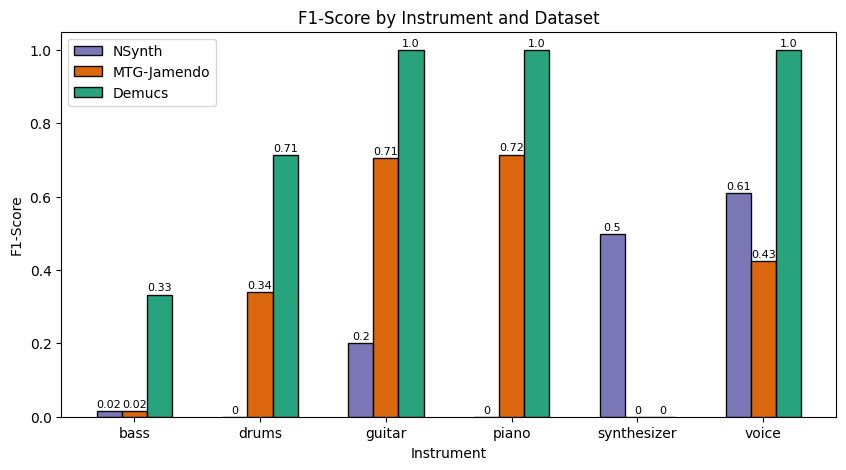

In [31]:
# plt.switch_backend('Agg')

instruments = ['bass', 'drums', 'guitar', 'piano', 'synthesizer', 'voice']

dataset1 = [d['F1-Score'] for d in data if d['dataset'] == 'NSynth']
dataset2 = [d['F1-Score'] for d in data if d['dataset'] == 'MTG-Jamendo']
dataset3 = [d['F1-Score'] for d in data if d['dataset'] == 'Demucs']
f1_scores = [dataset1, dataset2, dataset3]

bar_width = 0.2

r1 = np.arange(len(instruments))
r2 = [x + bar_width for x in r1]
r3 = [x + 2 * bar_width for x in r1]

plt.figure(figsize=(10,5))

plt.bar(r1, dataset1, color='#7570b3', width=bar_width, edgecolor='black', label='NSynth', alpha=0.95)
plt.bar(r2, dataset2, color='#d95f02', width=bar_width, edgecolor='black', label='MTG-Jamendo', alpha=0.95)
plt.bar(r3, dataset3, color='#1b9e77', width=bar_width, edgecolor='black', label='Demucs', alpha=0.95)

plt.xlabel('Instrument')
plt.ylabel('F1-Score')
plt.title('F1-Score by Instrument and Dataset')

plt.xticks(r1 + bar_width, instruments)

for i, dataset in enumerate(f1_scores):
    for j, score in enumerate(dataset):
        plt.text(r1[j] + (i * bar_width), score + 0.01, str(round(score, 2)), ha='center', fontsize=8)

plt.legend()
plt.show()
# plt.savefig('images/f1-score.png')

In [41]:
v1 = dataset1.copy()
v1.pop(1)
v1.pop(2)

v2 = dataset2.copy()
v2.pop(4)

v3 = dataset3.copy()
v3.pop(4)

0

In [40]:
print(np.mean(v1))
print(np.mean(v2))
print(np.mean(v3))

0.33092237942605424
0.4405446014288506
0.8095238095238095


In [44]:
cm = confusion_matrix(y_true_d, y_pred_d)
insts = np.unique(predicted_demucs['instrument'])

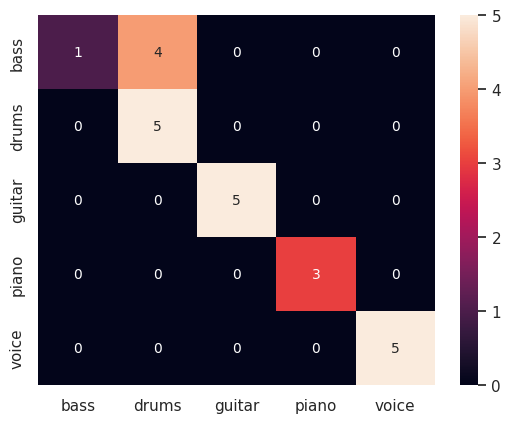

In [52]:
df_cm = pd.DataFrame(confusion_matrix(y_true_d, y_pred_d), index=insts, columns=insts)
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.0)
sns.heatmap(df_cm, annot=True, annot_kws={'size': 10}, fmt='g')

plt.show()


## Avaliando modelos Openmic em áudios com separação de instrumentos

In [22]:
audio, sr = librosa.load('separated/htdemucs_6s/come-a-little-closer-official-video/vocals.wav')
audio_splitted = remove_silence(audio, sr)
dur = librosa.get_duration(y=audio_splitted, sr=sr)
segments = split(audio_splitted, sr, dur, split_duration=5)

In [23]:
correct = 0

for segment in segments:
    _, features = vggish.waveform_to_features(segment, sr)
    feature_mean = np.mean(features, axis=0, keepdims=True)
    probs = []
    
    for instrument in instruments_openmic:
        with open(f'openmic/models/{instrument}.pkl', 'rb') as f:
            clf = pickle.load(f)
        prob = clf.predict_proba(feature_mean)[0,1]
        probs.append((instrument, prob))
        
    max_prob = max(probs, key=lambda x: x[1])
    
    if max_prob[0] == 'voice':
        correct += 1

print(f'{correct} correct assignments and {len(segments) - correct} wrong.')

INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /hom

In [42]:
audio, sr = librosa.load('separated/htdemucs_6s/nothing_else_matters/vocals.wav')
audio_splitted = remove_silence(audio, sr)
dur = librosa.get_duration(y=audio_splitted, sr=sr)
segments = split(audio_splitted, sr, dur, split_duration=5)

In [43]:
insts = {'bass': 0, 'drums': 0, 'guitar': 0, 'piano': 0, 'voice': 0}

for idx, segment in enumerate(segments):
    _, features = vggish.waveform_to_features(segment, sr)
    feature_mean = np.mean(features, axis=0, keepdims=True)
    probs = []
    
    for instrument in instruments_openmic:
        with open(f'openmic/models/{instrument}.pkl', 'rb') as f:
            clf = pickle.load(f)
        prob = clf.predict_proba(feature_mean)[0,1]
        probs.append((instrument, prob))
        
    max_prob = max(probs, key=lambda x: x[1])
    insts[max_prob[0]] += 1

print(insts)

INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /home/gabs/Documents/tcc/vggish/vggish/_model/vggish_model.ckpt
INFO:tensorflow:Restoring parameters from /hom